# Self-Driving Car Engineer Nanodegree


## Building a Traffic Sign Recognition Classifier

In [43]:
import pickle
import numpy as np
import string
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
import tensorflow as tf
import random as rnd
from   sklearn.utils import shuffle
import skimage
from skimage import io, transform, filters
from   tensorflow.contrib.layers import flatten
import cv2
import timeit

# Visualizations will be shown in the notebook.
%matplotlib inline
np.random.seed(3)


## Loading the data

In [44]:
# Load pickled data
# Choose whether to use augmented or the original data
LoadAugmentedData = False
SaveAugmentedData = False
UseAugmentedDataForTraining = False
LoadPreprocessed = False

if LoadAugmentedData:
    training_file   = "traffic-signs-data/train-augmented.p"
else:
    training_file   = "traffic-signs-data/train.p"
    
validation_file ="traffic-signs-data/valid.p"
testing_file    = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test   = test['features'],  test['labels']

---

## Step 1: Dataset Summary & Exploration


### Basic Summary of the Data Set

In [45]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = x_train.shape[0]

# TODO: Number of validation examples
n_validation = x_valid.shape[0]

# TODO: Number of testing examples.
n_test = x_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = x_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
unique_classes, class_counts = np.unique(y_train, return_counts=True)
n_classes = unique_classes.size

# Read the traffic sign names
signNames = read_csv("signnames.csv").values[:, 1]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

Sign 42: End of no passing by vehicles over 3.5 metric tons


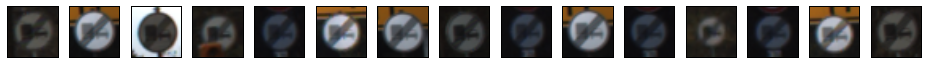

Sign 24: Road narrows on the right


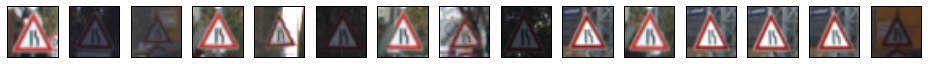

Sign 3: Speed limit (60km/h)


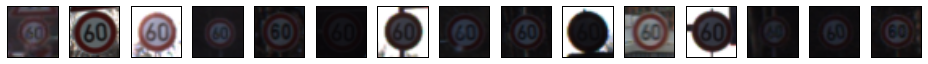

Sign 8: Speed limit (120km/h)


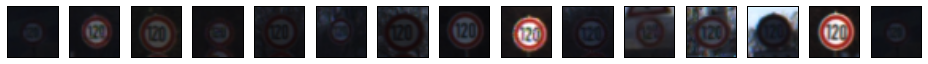

Sign 0: Speed limit (20km/h)


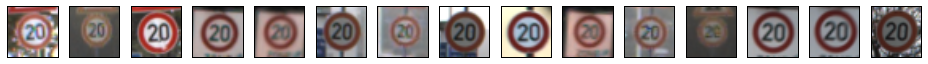

In [46]:
# Chose 10 random classes. Print 15 random images from each class

def showRandomImagesFromDataset(x, y, numClassesToShow, numImgsPerClass, names):

    classesToShow = np.random.randint(low=0, high=n_classes, size=numClassesToShow)

    for sign in classesToShow:
        #Get images for this sign
        print("Sign %i: %s" % (sign, names[sign]))
        imgsSign = x[y==sign]
        #choose 10 random signs
        imgsSign = imgsSign[np.random.randint(low=0, high=imgsSign.shape[0], size=numImgsPerClass), :,:,:]
        fig = plt.figure(figsize = (13, 1))
        for i in range(numImgsPerClass):
            plt.subplot(1, numImgsPerClass, i+1)
            plt.imshow(imgsSign[i,:,:,:])
            plt.xticks([])
            plt.yticks([])
        fig.tight_layout()
        plt.show()
        

showRandomImagesFromDataset(x_train, y_train, numClassesToShow=5, numImgsPerClass=15, names=signNames)        

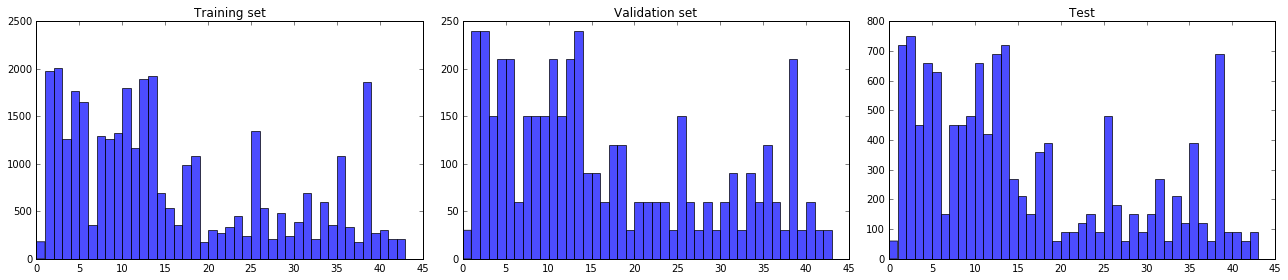

In [47]:
#Distributions of the training, validation and the test sets

yData = [y_train, y_valid, y_test]
compFig = plt.figure(figsize=(18, 4))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    ax.set_title(["Training set", "Validation set", "Test"][i])
    plt.hist(yData[i], bins=np.arange(yData[i].min(), yData[i].max()+2), color="blue", alpha=0.7)

compFig.tight_layout()
#plt.savefig('data-histograms.png', dpi=120, transparent=True, box_inches='Tight')
plt.show()


We see that, at least with respect to the number of images per class, the training, validation and the test set have been drawn from the same distribution. However, there is a big variation in the number of images in each class. There are very few images of certain classes and this could potentially lead to low classification accuracy for those. To mitigate this, we will try data augmentation - specially for classes that are under-represented.

### Data augmentation

In attempt to balance our dataset and (as we shall see later) to reduce overfitting, we will augment the dataset. New images will be created from existing images by randomly applying one or more of the following image transforms
- Translation
- Rotation
- Crop + resize
- Perspective
- Gaussion blur
- Additive noise
- Brightness changes

Although more transformations like flips and shear are possible and frequently used, we will not use them here because we will not physically encounter such images. For example, one would never encounter a flipped road sign. Or no physical phenomenon would cause images to get sheared (except perhaps rolling shutter artifacts but that would be relatively rare). 

Since there are already great libraries that perform data augmentation for us, we will use them instead for attempting to write our own. 

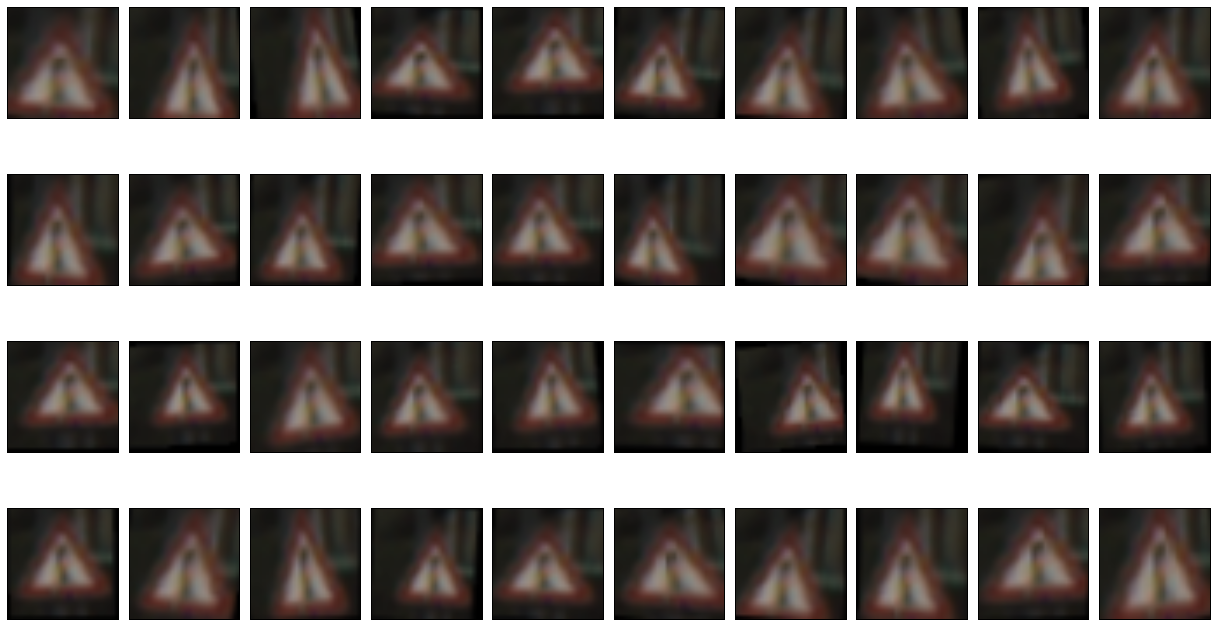

In [48]:
from imgaug import augmenters as iaa


seq = iaa.Sequential([
    # Crop all images with random percentage from 0 to 22%
    iaa.Crop(percent=(0, 0.22)), # random crops
    
    # With a probability of 0.3, apply either a random Gaussian 
    # blur or add random additive noise.
    iaa.Sometimes(0.3, 
    iaa.OneOf([
    iaa.GaussianBlur(sigma=(0, 1)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0 ,0.07*255))
    ])),
    
    # Strengthen or weaken the contrast in each image.
    #iaa.Sometimes(0.25, iaa.ContrastNormalization((0.75, 1.5))),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    
    # Translate some images
    iaa.Sometimes(0.25, 
                  iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
                 ),
    
    # With a high probability, apply a perspective transform
    iaa.Sometimes(0.97,
                  iaa.PerspectiveTransform(scale=(0, 0.1))
                 ),
    
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        rotate=(-6, 6)
    )
    
    #iaa.Affine(rotate=(89, 91))
], random_order=True)


def augmentSingleBatch(imgs, labels, ratio, sequence):
    # augment data
    augmented = np.repeat(imgs, repeats=ratio, axis=0)
    augmented = sequence.augment_images(augmented)
    
    #augment labels
    labels = np.repeat(labels, repeats=ratio, axis=0)
    return augmented, labels

def showRandomAugmentedImages(x, numImgs):
    cols = 10
    rows = np.ceil(numImgs/cols)
    
    chooseImgs = np.random.randint(0, x.shape[0], size=numImgs)    
    
    augFig = plt.figure(figsize=(17,10))
    for i, img in np.ndenumerate(chooseImgs):
        plt.subplot(rows, cols, i[0]+1)
        plt.imshow(x[img, :,:,:])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig('augmented.png', dpi=120, transparent=True, box_inches='Tight')
    plt.show()
    
def testAugmentationSequence(img, numImgs):
    augmented = np.repeat(np.reshape(img, (1, *img.shape)), repeats=numImgs, axis=0)
    #print(augmented.shape)
    augmented, _ = augmentSingleBatch(augmented, np.array([0]), ratio=2, sequence=seq)
    #print(augmented.shape)
    showRandomAugmentedImages(augmented, numImgs)

def extendDataset(x, y, ratio, sequence):   
    #TODO: Do this batch-wise
    x_aug, y_aug = augmentSingleBatch(x, y, ratio, sequence)
    return x_aug, y_aug

def balanceDataset(x,y, minsamples, sequence):
    x_aug, y_aug = np.empty(shape=(0, 32, 32, 3), dtype=np.uint8), np.empty(shape=(0), dtype=np.uint8)
    num = 0
    for sign in range(n_classes):
        signIdx = (y==sign)
        signNum = np.count_nonzero(signIdx)
        if signNum < 800:
            ratio = np.max([2.0, np.floor(1500.0/signNum)])
            #num = num + signNum*ratio
            batch_x, batch_y = augmentSingleBatch(x[signIdx, :,:,:], y[signIdx], ratio, sequence)
            x_aug = np.append(x_aug, batch_x, axis=0)
            y_aug = np.append(y_aug, batch_y, axis=0)
            #print(x_aug.shape, y_aug.shape)
        else:
            continue
    return x_aug,y_aug


#Visualize the augmentation pipline on a single image
i = 1474
testAugmentationSequence(x_train[i,:,:,:], 40)
        

In [49]:
# Run the augmentation on our training dataset
if ~LoadAugmentedData:
    x_aug, y_aug = balanceDataset(x_train, y_train, 1500, seq)
    print("%i new training samples generated" % y_aug.size)
    #print("Augem")
    print(x_aug.shape, y_aug.shape)
else:
    print("Data already augmented")

35818 new training samples generated
(35818, 32, 32, 3) (35818,)


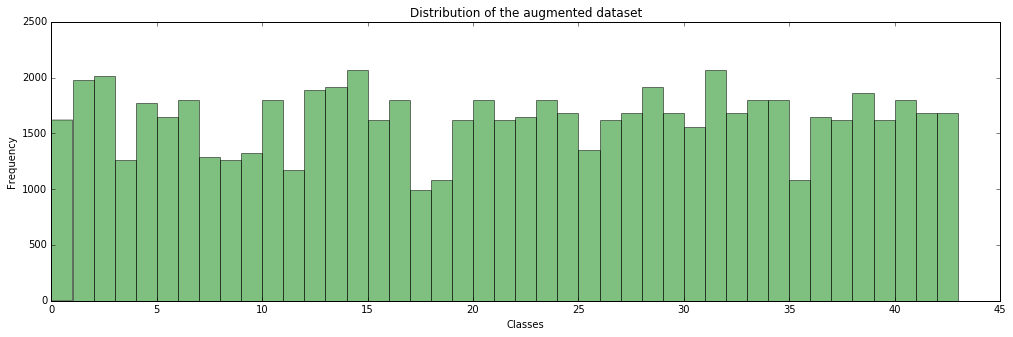

In [50]:
# Visualize the distribution of the augmented dataset
if ~LoadAugmentedData:
    x_train_aug = np.append(x_train, x_aug, axis=0)
    y_train_aug = np.append(y_train, y_aug, axis=0)
    
    augHist = plt.figure(figsize=(17,5))
    plt.title("Distribution of the augmented dataset")
    plt.hist(y_train_aug, bins=np.arange(y_train_aug.min(), y_train_aug.max()+2), color="green", alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel("Classes")
    plt.savefig('augmented-histogram.png', dpi=120, transparent=True, box_inches='Tight')
    plt.show()

    #showRandomImagesFromDataset(x_train_aug, y_train_aug, numClassesToShow=5, numImgsPerClass=15, names=signNames)
else:
    print("Data already augmented")


Clearly, the training dataset is much better balanced after the data augmentation.

In [51]:
if ~LoadAugmentedData and UseAugmentedDataForTraining:
    LoadAugmentedData = True #data is augmented from here on
    x_train, y_train = x_train_aug, y_train_aug
    del x_train_aug
    del y_train_aug
    print("Data augmented")
    
print(x_train.shape, y_train.shape)

(34799, 32, 32, 3) (34799,)


----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

The images are converted to grayscale and normalized with a simple min-max scheme.

In [52]:

def toGrayscale(imgStack):
    # Weights for grayscale conversion taken from 
    # https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
    # Doing it this way because it allows for a nice vectorized implementation
    grayStack = np.average(imgStack, axis=3, weights=[0.299,0.587, 0.114])
    grayStack = np.reshape(grayStack, (*grayStack.shape, 1))
    return grayStack
    

def Normalize(imgStack, min=0.1, max=0.9):
    dims = imgStack.shape
    vec = np.reshape(imgStack, [dims[0], -1])
    vecmax = np.max(vec, axis=1, keepdims=True)
    vecmin = np.min(vec, axis=1, keepdims=True)
    normed = min + (vec - vecmin)/(vecmax - vecmin)*(max - min)
    return np.reshape(normed, [-1, *dims[1:4]])
    

#if x_train.shape[3] == 3: #Preprocess only if not done before
# Conver to grayscale
x_train_n, x_valid_n, x_test_n = [toGrayscale(x)  for x in [x_train, x_valid, x_test]]

# Normalize all images to between -0.5 and 0.5
x_train_n, x_valid_n, x_test_n = [Normalize(x, 0.1, 0.9) for x in [x_train_n, x_valid_n, x_test_n]]
    

print(x_train.shape, x_train_n.shape)



(34799, 32, 32, 3) (34799, 32, 32, 1)


(34799, 32, 32, 3)
34799


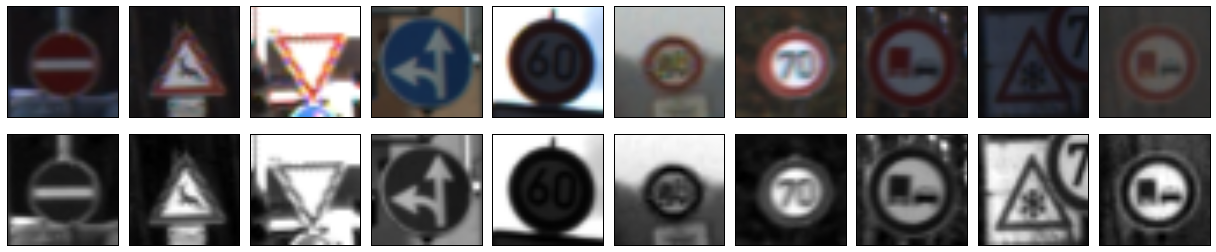

In [53]:
# Visualizing the normalized dataset

def showRandomNormalizedImages(xup, xdown, numImgs):
    print(xup.shape[0])
    chooseImgs = np.random.randint(0, xup.shape[0], size=numImgs)
    
    normFig = plt.figure(figsize=(17,4))
    for i, idx in np.ndenumerate(chooseImgs):
        plt.subplot(2, numImgs, i[0]+1)
        plt.imshow(xup[idx, :,:,:])
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2, numImgs, i[0]+numImgs+1)
        plt.imshow(xdown[idx, :,:,0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()
    #plt.savefig('preproc.png', dpi=120, transparent=True, box_inches='Tight')
    plt.show()
    
print(x_train.shape)
showRandomNormalizedImages(x_train, x_train_n, 10)


In [54]:
if ~LoadPreprocessed:
    LoadPreprocessed = True
    x_train, x_valid, x_test = x_train_n, x_valid_n, x_test_n
    del x_train_n
    del x_valid_n
    del x_test_n
else:
    print("Already pre-processed")

x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape)

(34799, 32, 32, 1)


### Model Architecture

In [55]:
tf.reset_default_graph()

def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def fc_layer(input_tensor, input_dim, output_dim, layer_name, activation=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            #variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            #variable_++summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            #tf.summary.histogram('pre_activations', preactivate)
        with tf.name_scope('activations'):
            act = activation(preactivate, name='activation')
        #tf.summary.histogram('activations', act)
        return act, weights

def conv_layer(input, input_dim, output_dim, layer_name, kernel_size, stride, padding='SAME'):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = weight_variable([kernel_size, kernel_size, input_dim, output_dim])
            #variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            #variable_summaries(biases)
        with tf.name_scope('conv'):
            conv = tf.nn.conv2d(input, weights, strides=[1, stride, stride, 1], padding=padding)
            #variable_summaries(conv)
        with tf.name_scope('activations'):
            act = tf.nn.relu(conv + biases)
        #tf.summary.histogram('activations', act)
        with tf.name_scope('maxpools'):
            pools = tf.nn.max_pool(act, ksize=[1,2,2,1], strides=[1,2,2,1], padding=padding)
        return pools

def pool_layer(input, size,  layer_name, padding='SAME'):
    # No name scopes here. We'll define these in the model
    return tf.nn.max_pool(input,  ksize=[1,size,size,1], strides=[1,size,size,1], padding=padding)
    
def LeNet(x, returnActivations = False):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    ### Convolution layers
    # Layer 1: Convolutional. Input = 32x32x1. Output Conv = 32x32x16. Output Pool = 16x16x16
    P1 = conv_layer(x, input_dim=1, output_dim=16, layer_name="CONV1", kernel_size=5, stride=1, padding='SAME')
        
    # Layer 2: Convolutional. Input = 16x16x16, Output Conv = 16x16x32. Output pool = 8x8x16
    P2 = conv_layer(P1, input_dim=16, output_dim=32, layer_name="CONV2", kernel_size=5, stride=1, padding='SAME')
    
    # Flatten them all and pass on to a fully-connected layer  
    #with tf.name_scope("flatten"):
    # Sub-sample P1 more before passing it on
    FP1 = pool_layer(P1, size=2, padding='VALID', layer_name='pool1')
    with tf.name_scope("flatten"):
        FP1 = tf.contrib.layers.flatten(FP1)
        FP2 = tf.contrib.layers.flatten(P2)

    FIN = tf.concat([FP1, FP2], axis=1, name="concat1")

    # Add a dropout
    FIN = tf.layers.dropout(inputs=FIN, rate=0.4, name="dropout1")
    
    # Layer 4: Fully Connected. 
    F4, W4 = fc_layer(FIN, input_dim=3072, output_dim=1024, layer_name="FC1", activation=tf.nn.relu) #was 160
    D4 = tf.layers.dropout(inputs=F4, rate=0.4, name="dropout2")
    
    # Layer 5: Fully Connected. 
    F5, W5 = fc_layer(D4, input_dim=1024, output_dim=43, layer_name="FC2", activation=tf.identity)    
    
    logits = F5
    
    if returnActivations:
        return logits, [W4, W5], [P1, P2]
    else:
        return logits, [W4, W5]

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [56]:
# Process training data and create placeholders for them
#x = tf.placeholder(tf.float32, (None, *image_shape), name="x")
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name="x")
y = tf.placeholder(tf.int32, (None), name="labels")

def toOneHot(y, numLabels):
    if tf.__version__ == "0.12.1":
        sparse_labels=tf.reshape(y,[-1,1])
        derived_size=tf.shape(sparse_labels)[0]
        indices=tf.reshape(tf.range(0,derived_size,1),[-1,1])
        concated=tf.concat(1,[indices,sparse_labels])
        outshape=tf.concat(0,[tf.reshape(derived_size,[1]),tf.reshape(numLabels,[1])])
        return tf.sparse_to_dense(concated, outshape,1.0,0.0)
    else:
        return tf.one_hot(y, numLabels)
    
y_oh = toOneHot(y, n_classes)

In [57]:
# Errors, loss and optimizers
rate = 0.002
EPOCHS = 50
BATCH_SIZE = 128
L2_REG = 0.000000

In [58]:
logits, weights, activations = LeNet(x, returnActivations=True)

with tf.name_scope("loss"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=logits))
    l2_loss = L2_REG*(
        tf.nn.l2_loss(weights[0]) + tf.nn.l2_loss(weights[1]))
    loss_operation = tf.reduce_mean(cross_entropy + l2_loss)
    tf.summary.scalar("loss", loss_operation)
    
    
with tf.name_scope("optimizer"):    
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

In [59]:
# Model evaluation and accuracy in TensorFlow
with tf.name_scope("prediction"):
    prediction_operation = tf.argmax(logits, 1)

with tf.name_scope("accuracy"):
    correctness = tf.equal(prediction_operation, tf.argmax(y_oh, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correctness, tf.float32))

# Function to make prediction in batches
def makePredictions(x_data):
    num = len(x_data)
    prediction = np.empty(shape=(0,0), dtype=np.float64)
    sess = tf.get_default_session()
    for offset in range(0, num, BATCH_SIZE):
        batch_x = x_data[offset:offset+BATCH_SIZE]
        batch_prediction = sess.run(prediction_operation, feed_dict={x: batch_x})
        prediction = np.append(prediction, batch_prediction)
        
    return prediction

# Function to evaluate the accuracy in batches
def evalAccuracy(x_data, y_data):
    num_examples = len(y_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        #accuracy_operation = accuracy_logits(logits, y_oh)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Accuracy computation in NumPy
def computeAccuracy(prediction, labels):
    correctness = (prediction == labels)
    return np.count_nonzero(correctness)/correctness.size
        
saver = tf.train.Saver()

In [60]:
# Create a random file name for this run
modelName = 'lenet-'+''.join(rnd.choice(string.ascii_uppercase + string.digits) for _ in range(6))

with tf.Session() as sess:
    print("Initializing")
    sess.run(tf.global_variables_initializer())
    #summary_operation = tf.summary.merge_all()
    graphwriter = tf.summary.FileWriter("./logs")
    graphwriter.add_graph(sess.graph)
    
    num_examples = len(x_train)
    
    print("Training started")
    start_time = timeit.default_timer()
    for i in range(EPOCHS):
        #x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            loss, _ = sess.run([loss_operation, training_operation], \
                                feed_dict={x: batch_x, y: batch_y})
        
        #s = sess.run(summary_operation, feed_dict={x: batch_y, y:batch_y})
        #graphwriter.add_summary(s, i)
        valid_accuracy = evalAccuracy(x_valid, y_valid)
        print("Epoch %i, Loss %f, Validation: %.3f" % (i+1, loss, valid_accuracy))
        
    elapsed = timeit.default_timer() - start_time
    
    # Evaluate training and validation accuracies
    predictions_valid      = makePredictions(x_valid)
    predictions_training   = makePredictions(x_train)
    print("Training accuracy %f"   % computeAccuracy(predictions_training, y_train))
    print("Validation accuracy %f" % computeAccuracy(predictions_valid, y_valid))
    
    if(computeAccuracy(predictions_valid, y_valid) > 0.955):
        saver.save(sess, './models/'+ modelName)
        print('Model saved as: ' + modelName)

print()
print("Training time: %fs" % elapsed)

Initializing
Training started
Epoch 1, Loss 0.278055, Validation: 0.837
Epoch 2, Loss 0.066929, Validation: 0.865
Epoch 3, Loss 0.046068, Validation: 0.888
Epoch 4, Loss 0.022495, Validation: 0.901
Epoch 5, Loss 0.014580, Validation: 0.888
Epoch 6, Loss 0.001995, Validation: 0.904
Epoch 7, Loss 0.001355, Validation: 0.907
Epoch 8, Loss 0.008153, Validation: 0.905
Epoch 9, Loss 0.025413, Validation: 0.882
Epoch 10, Loss 0.005216, Validation: 0.909
Epoch 11, Loss 0.003783, Validation: 0.914
Epoch 12, Loss 0.019727, Validation: 0.908
Epoch 13, Loss 0.000519, Validation: 0.912
Epoch 14, Loss 0.004868, Validation: 0.933
Epoch 15, Loss 0.000147, Validation: 0.944
Epoch 16, Loss 0.005717, Validation: 0.925
Epoch 17, Loss 0.000218, Validation: 0.929
Epoch 18, Loss 0.000890, Validation: 0.921
Epoch 19, Loss 0.005313, Validation: 0.926
Epoch 20, Loss 0.000094, Validation: 0.922
Epoch 21, Loss 0.044247, Validation: 0.937
Epoch 22, Loss 0.000309, Validation: 0.93
Epoch 23, Loss 0.002555, Validatio

### Analysis of performance and mispredictions


We will look at the results of the model and analyse the mispredictions

In [61]:
#tf.reset_default_graph()
def runModelLogits(modelpath, inputx):
    with tf.Session() as sess:
        #saver = tf.train.import_meta_graph('./models/lenet-O6CJA9.meta')
        saver.restore(sess, modelpath)
        runLogits = sess.run(logits, feed_dict={x: inputx})
        return runLogits

def predictWithMax(logits):
    return np.argmax(logits, axis=1)

def predictWithSoftmax(logits):
    expLogits = np.exp(logits)
    return expLogits/np.sum(expLogits)


Classes with lowest F-score: [[24  0]
 [41  0]]


<function matplotlib.pyplot.show>

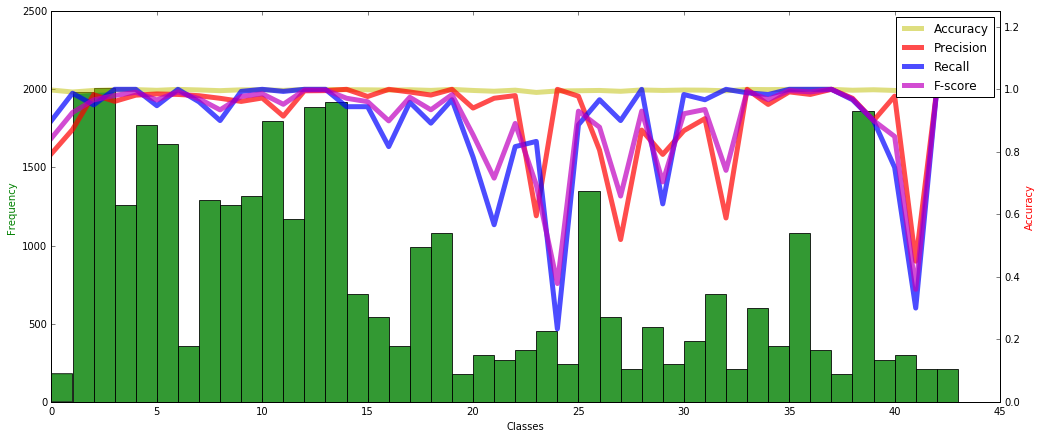

In [62]:
# Analyze the model on validation data

correctness   = (predictions_valid == y_valid)
classAccuracy = np.zeros((n_classes,1))
classPrecision = np.zeros((n_classes,1))
classRecall = np.zeros((n_classes,1))
classFscore = np.zeros((n_classes,1))
for sign in range(n_classes):
    #sign = 6
    idxDataset = (y_valid == sign) #Indices of signs of this type in the dataset
    numSign    = np.count_nonzero(idxDataset)   #Number  of signs of this type in the dataset

    idxDetected = (predictions_valid == sign) #Indcies of signs of this type detected
    numDetected = np.count_nonzero(idxDetected) #Number of signs of this type detected

    numTruePos  = np.count_nonzero(np.logical_and(idxDataset, idxDetected))
    classPrecision[sign] = numTruePos/numDetected
    classRecall[sign] = numTruePos/numSign

    
    signaccuracy = np.count_nonzero(idxDataset == idxDetected)/correctness.size
    #signcorrectness = correctness[idxDataset]
    #signaccuracy = np.count_nonzero(correctness)/correctness.size
    classAccuracy[sign] = signaccuracy

classFscore = 2/(1/classPrecision + 1/classRecall)    
    
print("Classes with lowest F-score:", np.argwhere(classFscore < 0.6)) 
    
compFig, compax1 = plt.subplots(figsize=(17,7))
compax1.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2), color='g', alpha=0.8)
compax1.set_xlabel("Classes")
compax1.set_ylabel('Frequency', color='g')

compax2 = compax1.twinx()
compax2.plot(np.arange(n_classes), classAccuracy,  'y-', alpha=0.5, linewidth=5, label="Accuracy")
compax2.plot(np.arange(n_classes), classPrecision, 'r-', alpha=0.7, linewidth=5, label="Precision")
compax2.plot(np.arange(n_classes), classRecall,    'b-', alpha=0.7, linewidth=5, label="Recall")
compax2.plot(np.arange(n_classes), classFscore,    'm-', alpha=0.7, linewidth=5, label="F-score")
compax2.set_ylabel('Accuracy', color='r')
compax2.set_ylim([0,1.25])
plt.legend()
plt.savefig('classwise-final.png', dpi=120, transparent=True, box_inches='Tight')
plt.show

In [ ]:
# Rough code scribbles to display mis-classifications
idx = 24
falseNeg = np.logical_and((predictions_valid != idx), (y_valid==idx))
truePos  = np.logical_and((predictions_valid == idx), (y_valid==idx))

sample = x_valid[falseNeg, :,:,0]
print(sample.shape)
plt.imshow(sample[2, :,:], cmap="gray")
plt.show()

sample = x_valid[truePos, :,:,0]
print(sample.shape)
plt.imshow(sample[0, :,:], cmap="gray")
plt.show()


print(predictions_valid[y_valid==idx])

sample = x_valid[(y_valid==18), :,:,0]
print(sample.shape)
plt.imshow(sample[1, :,:], cmap="gray")
plt.show()


---

## Step 3: Test a Model on New Images


### Load and Output the Images

(8, 32, 32, 3)


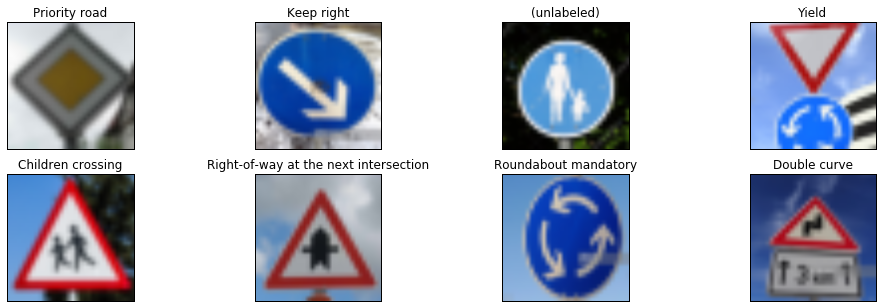

In [63]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

x_field = np.zeros((8, 32, 32, 3))
for i in range(8):
    filename = 'fieldtest/%i.jpg' % (i+1)
    img = skimage.io.imread(filename)
    img = skimage.filters.gaussian(img, sigma=9, multichannel=True)
    img = skimage.transform.resize(img, (32, 32), mode='constant')
    x_field[i, :,:,:] = img
    #plt.imshow(img)
    #plt.show()

# Manually label the dataset
y_field = np.array([12,38,44,13,28,11,40,21])
print(x_field.shape)

# Show the images and their labels
figField = plt.figure(figsize=(17, 5))
for i in range(8):
    plt.subplot(2,4, i+1)
    plt.imshow(x_field[i,:,:,:])
    sign = signNames[y_field[i]] if y_field[i] < 43 else '(unlabeled)'
    plt.title(sign)
    plt.xticks([])
    plt.yticks([])
    
#plt.savefig('field-images.png', dpi=120, transparent=True, box_inches='Tight')
plt.show() 

# Process the images
x_field_n = Normalize(toGrayscale(x_field), 0.1, 0.9)

### Predict the Sign Type for Each Image

In [65]:
def analyzeFieldImages(modelpath, inputx):
        with tf.Session() as sess:
            #saver = tf.train.import_meta_graph('./models/lenet-O6CJA9.meta')
            predSftMax = tf.nn.softmax(logits)
            predTopk   = tf.nn.top_k(predSftMax, k=3)
            saver.restore(sess, modelpath)
            runLogits, topk = sess.run([logits, predTopk], feed_dict={x: inputx})
        return runLogits, topk
    

runLogits, topk = analyzeFieldImages('./models/lenet-JZZZBR', x_field_n)

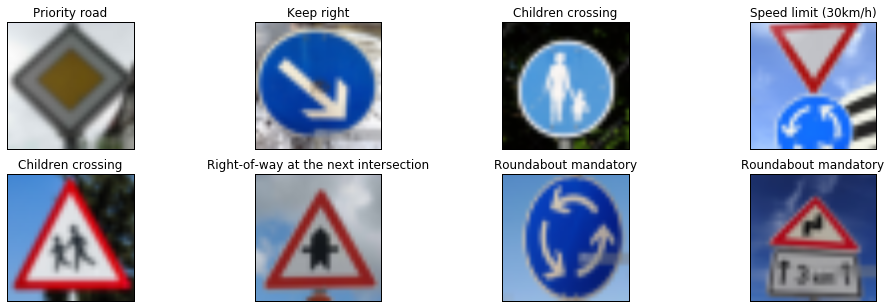

In [66]:
maxPredictions = predictWithMax(runLogits)

# Show the images and their predictions
figField = plt.figure(figsize=(17, 5))
for i in range(8):
    plt.subplot(2,4, i+1)
    plt.imshow(x_field[i,:,:,:])
    plt.title(signNames[maxPredictions[i]])
    plt.xticks([])
    plt.yticks([])
#plt.savefig('field-images-pred.png', dpi=120, transparent=True, box_inches='Tight')
plt.show()

### Analyze Performance

Clearly we have 5 correct classifications of 8 - which is 62% accuracy. Let us analyze the performance in detail by see the top 3 predictions for each sign.

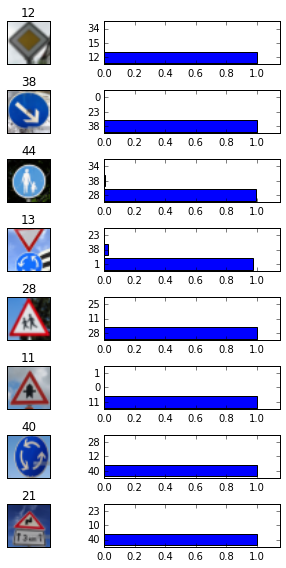

In [67]:
topFig = plt.figure(figsize=(5,8))
for i in range(8):
    plt.subplot(8, 2, 2*i+1)
    plt.imshow(x_field[i,:,:,:])
    #sign = signNames[y_field[i]] if y_field[i] < 43 else '(unlabeled)'
    plt.title(y_field[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8,2,2*i+2)
    xlabels = np.char.mod('%d', topk.indices[i,:])
    plt.barh(np.arange(3), topk.values[i,:], align='center')
    plt.yticks(np.arange(3), xlabels)
    plt.xlim([0,1.15])
plt.tight_layout()    
#plt.savefig('field-images-softmax.png', dpi=120, transparent=True, box_inches='Tight')
plt.show()
    

Interestingly, the model is quite sure of its (even incorrect) predictions.

---

## Visualize the Neural Network's State with Test Images

Next we try and visualize the layer 1 activations. For two images - one for a true negative (a mountain) and another for a sign that our model classfied well.

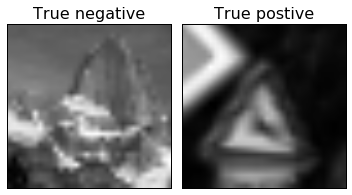

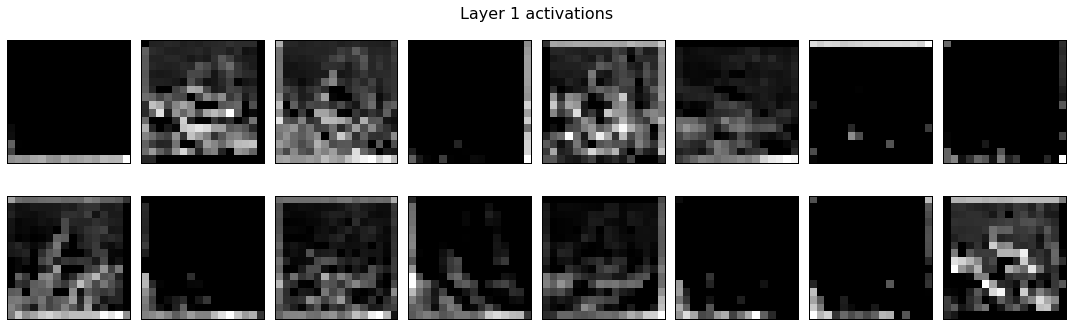

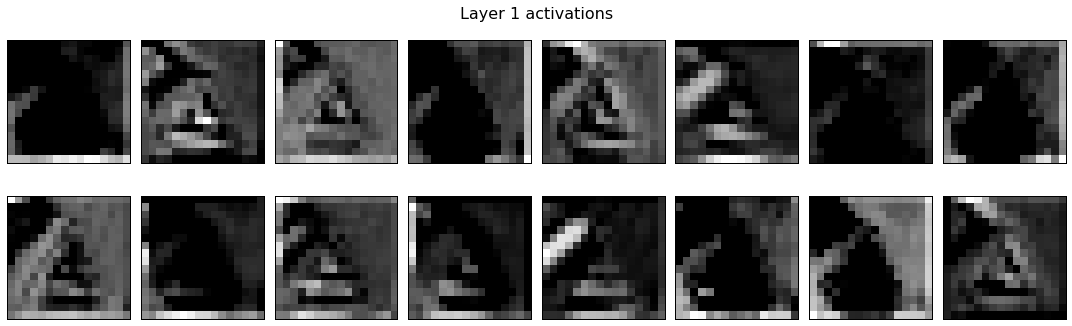

In [68]:

def visualizeLayer(modelpath, inputx):
    with tf.Session() as sess:
        saver.restore(sess, modelpath)
        layerOut = sess.run(activations, feed_dict={x: inputx})
        
        #Choose only the first layer
        layer = 0;
        layerActs = layerOut[layer]
        featuremaps = layerActs.shape[3]
        #print(featuremaps)
        
        image1Fig = plt.figure(figsize=(15,5))
        plt.suptitle("Layer 1 activations", fontsize='16')
        cols = 8
        rows = np.ceil(featuremaps/cols)
        for f in range(featuremaps):
            plt.subplot(rows, cols, f+1)
            plt.imshow(layerActs[0,:,:,f], interpolation="nearest", cmap = 'gray')
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.savefig('act-image1.png', dpi=120, transparent=True, box_inches='Tight')
        plt.show()
        
        
        image2Fig = plt.figure(figsize=(15,5))
        plt.suptitle("Layer 1 activations", fontsize='16')
        cols = 8
        rows = np.ceil(featuremaps/cols)
        for f in range(featuremaps):
            plt.subplot(rows, cols, f+1)
            plt.imshow(layerActs[1,:,:,f], interpolation="nearest", cmap = 'gray')
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.savefig('act-image2.png', dpi=120, transparent=True, box_inches='Tight')
        plt.show()
        
        

## Pick the images
visImgs = np.zeros((2, 32, 32, 1))
# One from the disk

img = skimage.io.imread('fieldtest/15.jpg')
img = skimage.filters.gaussian(img, sigma=5, multichannel=True)
img = skimage.transform.resize(img, (32, 32), mode='constant')
img = np.reshape(img, (1, *img.shape))
visImgs[0,:,:,:] = Normalize(toGrayscale(img), 0.1, 0.9)

# One among true positives
truePosImg = x_valid[(predictions_valid == y_valid), :,:,:]
visImgs[1,:,:,:] = truePosImg[68,:,:,:]

visFig = plt.figure(figsize=(5,8))
plt.subplot(1, 2, 1)
plt.imshow(visImgs[0,:,:,0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("True negative", fontsize=16)
plt.subplot(1, 2, 2)
plt.imshow(visImgs[1,:,:,0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("True postive", fontsize=16)
plt.tight_layout()
plt.savefig('act-images.png', dpi=60, transparent=True, box_inches='Tight')
plt.show

# Visualize the activations
visualizeLayer('./models/lenet-G4RF2H', visImgs) #not well trained